In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import re
from pathlib import Path
from typing import List
from langchain_openai import ChatOpenAI
from tavily import TavilyClient

from pydantic import BaseModel, Field

from typing import TypedDict, List, Any, Optional, Dict
from typing import Annotated, Literal
from operator import add
from langgraph.graph import StateGraph, START, END

import pandas as pd
import json
import os

In [3]:
OPEN_API_KEY = os.getenv('OPEN_API_KEY')

LANGSMITH_TRACING = os.getenv('LANGSMITH_TRACING')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
LANGSMITH_PROJECT = os.getenv('LANGSMITH_PROJECT')
LANGSMITH_ENDPOINT = os.getenv('LANGSMITH_ENDPOINT')

TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [4]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

Tools added:
- Tavily search tool
    - Task: Get the URLs, content, and title of where the dataset is located.
    - Input: A user query
    - Output: A TavilySearchOutput consisting of URLs, Title, Content
- Download Kaggle Files
    - Task: Download each Kaggle dataset URL into its own folder and return structured bundles for UI/analysis.
    - Input: Output from Tavily Search Tool (TavilySearchOutput)
    - Output: A list of DownloadedDataset objects, each containing:
        - source_url: The original Kaggle dataset URL
        - source_id: The Kaggle dataset identifier (e.g., "username/dataset-name")
        - display_name: (Optional) A human-readable name for the dataset
        - dest_dir: The local directory where the dataset was downloaded
        - files: A list of FileRecord objects for each file downloaded, with path, rel_path, and ext
        - meta: Additional metadata (e.g., download status, errors, timestamps)

In [5]:
# Initialize Tavily client
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

In [6]:
# For Tavily search

class TavilySearchOutput(BaseModel):
    title: str
    url: str
    content: str

class FileRecord(BaseModel):
    path: str
    rel_path: str
    ext: str
    name: Optional[str] = None
    size_bytes: Optional[int] = None

class DownloadedDataset(BaseModel):
    source_url: str
    source_id: str
    display_name: Optional[str] = None
    dest_dir: str
    files: List[FileRecord]
    meta: Dict[str, Any] = Field(default_factory=dict)


# Metadata output models

class FileOutput(BaseModel):
    file_path: str
    file_format: Optional[str] = None
    file_size: Optional[int] = None
    num_rows: Optional[int] = None
    num_columns: Optional[int] = None
    num_rows_with_missing: Optional[int] = None
    num_columns_with_missing: Optional[int] = None
    column_dtypes: Optional[Dict[str, str]] = None

class DatasetOutput(BaseModel):
    source_url: str
    num_files: int
    description: Optional[str] = None
    possibilities: Optional[Literal["classification", "regression", "clustering", "time_series", "text_generation", "image_generation", "other"]] = None
    files: List[FileOutput] = Field(default_factory=list)

In [7]:
class AgentState(TypedDict):
    query: str
    tavilySearchOutput: List[TavilySearchOutput]
    status: Annotated[List[str], add]
    download_results: Annotated[List[DownloadedDataset], add]
    dataset_outputs: Annotated[List[DatasetOutput], add]


In [8]:
# This function takes your search term, looks it up on dataset-heavy sites, filters duplicates, and returns a clean list of dataset pages.

def tavily_search_tool(state: AgentState):
    """Search Kaggle only and return up to 10 most relevant, deduped dataset links."""
    query = state["query"]

    site_queries = {
        "kaggle": f"{query} dataset site:kaggle.com/datasets"
    }

    def which_site(url: str) -> str | None:
        u = url.lower()
        if "kaggle.com/datasets/" in u:
            return "kaggle"
        return None

    def relevance_score(site: str, title: str, url: str, content: str) -> float:
        t = (title or "").lower()
        u = (url or "").lower()
        c = (content or "").lower()
        score = 0.0
        if any(x in u for x in [".csv", ".xlsx", ".json", "/download", "/raw/"]):
            score += 3.0
        if any(x in c for x in ["csv", "xlsx", "json", "download"]):
            score += 2.0
        for tok in set(query.lower().split()):
            if tok and (tok in t or tok in c):
                score += 0.5
        if site == "kaggle":
            score += 0.5
        return score

    candidates: list[tuple[str, TavilySearchOutput, float]] = []
    seen_urls: set[str] = set()

    # Collect per-site, compute scores (Kaggle only)
    for site, q in site_queries.items():
        try:
            r = tavily_client.search(query=q, search_depth="basic", max_results=15)
        except Exception:
            continue
        if not isinstance(r, dict) or "results" not in r:
            continue
        for h in r["results"]:
            url = h.get("url", "") if isinstance(h, dict) else ""
            site_name = which_site(url) if url else None
            if site_name is None:
                continue
            if url in seen_urls:
                continue
            seen_urls.add(url)
            title = h.get("title", "")
            content = h.get("content", "")
            tso = TavilySearchOutput(title=title, url=url, content=content)
            score = relevance_score(site_name, title, url, content)
            candidates.append((site_name, tso, score))

    candidates.sort(key=lambda x: x[2], reverse=True)

    selected: list[TavilySearchOutput] = []
    used_urls: set[str] = set()

    for _, tso, _ in candidates:
        if len(selected) >= 10:
            break
        if tso.url in used_urls:
            continue
        selected.append(tso)
        used_urls.add(tso.url)

    return { "tavilySearchOutput": selected, "status": ["Gathered Kaggle urls"] }

# Get datasest from Kaggle

## Tool to download Kaggle Files: download_kaggle_files

In [9]:
def download_kaggle_files(state: AgentState, data_dir: str = './data') -> dict:
    """
    Download each Kaggle URL into its own folder and return structured bundles for UI/analysis.
    """

    

    urls = [tso.url for tso in state['tavilySearchOutput']]

    api = KaggleApi()
    api.authenticate()

    base_dir = Path(data_dir) / 'kaggle'
    base_dir.mkdir(parents=True, exist_ok=True)

    def sanitize_slug(slug: str) -> str:
        # 'owner/name' -> 'owner__name' and strip unsafe chars
        return re.sub(r'[^a-zA-Z0-9._-]+', '_', slug.replace('/', '__'))

    bundles: List[DownloadedDataset] = []

    for url in urls:
        # Extract dataset slug from URL
        m = re.search(r'kaggle\.com/datasets/([^/]+/[^/?#]+)', url)
        if not m:
            continue
        slug = m.group(1)
        owner = slug.split('/')[0]
        name = slug.split('/')[-1]

        dest_dir = base_dir / sanitize_slug(slug)
        dest_dir.mkdir(parents=True, exist_ok=True)

        api.dataset_download_files(
            slug,
            path=str(dest_dir),
            force=False,
            quiet=True,
            unzip=True
        )

        files: List[FileRecord] = []
        for p in dest_dir.rglob('*'):
            if p.is_file():
                try:
                    size = p.stat().st_size
                except Exception:
                    size = 0
                files.append(FileRecord(
                    path=str(p.resolve()),
                    rel_path=str(p.relative_to(dest_dir)),
                    ext=p.suffix.lower(),
                    name=p.name,
                    size_bytes=int(size) if size is not None else None,
                ))


        bundles.append(DownloadedDataset(
            source_url=url,
            source_id=slug,
            display_name=name,
            dest_dir=str(dest_dir.resolve()),
            files=files,
            meta={
                'owner': owner,
                'num_files': len(files),
            }
        ))

    return {"download_results": bundles, "status": ["Downloaded Kaggle bundles"]}

In [10]:
def get_metadata(state: AgentState):

    bundles = state.get("download_results", []) if isinstance(state, dict) else []

    def infer_possibility_simple(files: List[FileOutput]) -> str:
        """
        Attempts to infer the type of ML problem from a list of FileOutput objects.
        This version uses a voting/aggregation approach across all files and columns,
        and considers more signals, including column counts, label uniqueness, and dtype ambiguity.
        """
        from collections import Counter

        # Heuristics and signals
        numeric_types = {"int", "float", "double", "decimal", "number"}
        text_types = {"object", "string", "str", "text", "category"}
        time_types = {"date", "time", "timestamp", "datetime"}
        label_keywords = {"target", "label", "sentiment", "class", "rating", "price", "value", "score", "output", "y"}

        votes = Counter()
        label_col_candidates = []

        for fo in files:
            col_dtypes = getattr(fo, "column_dtypes", None)
            if not col_dtypes or not isinstance(col_dtypes, dict):
                continue

            # Try to find label-like columns and gather their dtypes
            for col, dt in col_dtypes.items():
                lc = (col or "").lower()
                sd = (dt or "").lower()
                if any(x in lc for x in label_keywords):
                    label_col_candidates.append((col, sd))

                # Vote for time series if any time-like column
                if any(x in lc for x in time_types) or any(x in sd for x in time_types):
                    votes["time_series"] += 1
                # Vote for numeric
                if any(x in sd for x in numeric_types):
                    votes["numeric"] += 1
                # Vote for text
                if any(x in sd for x in text_types):
                    votes["text"] += 1

        # If label columns found, analyze their types and uniqueness
        if label_col_candidates:
            for col, sd in label_col_candidates:
                if any(x in sd for x in numeric_types):
                    votes["regression"] += 1
                elif any(x in sd for x in text_types):
                    votes["classification"] += 1
                else:
                    votes["classification"] += 1  # Default to classification if ambiguous

        # If time series votes dominate, return time_series
        if votes["time_series"] > 0:
            return "time_series"
        # If regression votes dominate, return regression
        if votes["regression"] > 0:
            return "regression"
        # If classification votes dominate, return classification
        if votes["classification"] > 0:
            return "classification"
        # If both numeric and text columns, likely classification
        if votes["numeric"] > 0 and votes["text"] > 0:
            return "classification"
        # If only numeric, fallback to regression
        if votes["numeric"] > 0:
            return "regression"
        # If only text, fallback to classification
        if votes["text"] > 0:
            return "classification"
        return "other"

    dataset_outputs: List[DatasetOutput] = []
    file_outputs: List[FileOutput] = []

    for bundle in bundles:
        files_for_dataset: List[FileOutput] = []
        for file in bundle.files:
            file_path = file.path
            file_ext = file.ext.lower()
            file_size = file.size_bytes
            fo = FileOutput(
                file_path=file_path,
                file_format=file_ext.replace('.', ''),
                file_size=file_size,
                num_rows=None,
                num_columns=None,
                num_rows_with_missing=None,
                num_columns_with_missing=None,
                column_dtypes=None
            )
            try:
                if file_ext == ".csv":
                    df = pd.read_csv(file_path)
                elif file_ext in [".xlsx", ".xls"]:
                    df = pd.read_excel(file_path)
                elif file_ext == ".json":
                    with open(file_path, "r", encoding="utf-8") as f:
                        data = json.load(f)
                    if isinstance(data, list):
                        df = pd.DataFrame(data)
                    elif isinstance(data, dict):
                        df = pd.json_normalize(data)
                    else:
                        df = None
                else:
                    df = None

                if df is not None:
                    fo.num_rows = int(df.shape[0])
                    fo.num_columns = int(df.shape[1])
                    fo.column_dtypes = {str(col): str(dtype) for col, dtype in df.dtypes.items()}
                    isnull = df.isnull()
                    fo.num_rows_with_missing = int(isnull.any(axis=1).sum())
                    fo.num_columns_with_missing = int(isnull.any(axis=0).sum())
            except Exception:
                pass
            files_for_dataset.append(fo)
            file_outputs.append(fo)

        # Build detailed context for the LLM with per-file schema and sample columns
        file_ctx_list = []
        for fo_item in files_for_dataset:
            file_ctx_list.append({
                "file_path": fo_item.file_path,
                "name": Path(fo_item.file_path).name if fo_item.file_path else None,
                "format": fo_item.file_format,
                "num_rows": fo_item.num_rows,
                "num_columns": fo_item.num_columns,
                "num_rows_with_missing": fo_item.num_rows_with_missing,
                "num_columns_with_missing": fo_item.num_columns_with_missing,
                "column_dtypes": fo_item.column_dtypes,
                "sample_columns": list(fo_item.column_dtypes.keys())[:15] if fo_item.column_dtypes else None,
            })
        llm_context = {
            "source_url": bundle.source_url,
            "source_id": getattr(bundle, "source_id", None),
            "display_name": getattr(bundle, "display_name", None),
            "owner": (bundle.meta or {}).get("owner") if hasattr(bundle, "meta") else None,
            "num_files": len(files_for_dataset),
            "files": file_ctx_list,
        }

        llm_for_meta = ChatOpenAI(model="gpt-4o", temperature=0.5)

        prompt = (
            "You are analyzing ONE specific Kaggle dataset link.\n"
            "Craft a dataset-specific 1–2 sentence description that references what the files and columns indicate.\n"
            "Be concrete and unique to this dataset; mention dataset-specific hints (e.g., file names, label fields, text vs numeric, dates) if helpful.\n"
            "Then choose the single best-use category for modeling from {classification, regression, clustering, time_series, text_generation, image_generation, other}.\n"
            "Output STRICT JSON only with keys 'description' and 'possibilities'. No preamble.\n\n"
            f"Dataset identification:\n"
            f"- source_url: {llm_context['source_url']}\n"
            f"- source_id: {llm_context.get('source_id')}\n"
            f"- display_name: {llm_context.get('display_name')}\n"
            f"- owner: {llm_context.get('owner')}\n"
            f"File summaries JSON: {json.dumps(file_ctx_list) }"
        )

        description = None
        possibility = None
        try:
            resp = llm_for_meta.invoke(prompt)
            content = getattr(resp, "content", "")
            start = content.find("{")
            end = content.rfind("}")
            if start != -1 and end != -1 and end > start:
                js = content[start : end + 1]
                data = json.loads(js)
                description = (data.get("description") or "").strip() or None
                poss = (data.get("possibilities") or "").strip().lower()
                allowed = {"classification","regression","clustering","time_series","text_generation","image_generation","other"}
                possibility = poss if poss in allowed else None
        except Exception:
            pass

        if possibility is None:
            possibility = infer_possibility_simple(files_for_dataset)

        ds = DatasetOutput(
            source_url=bundle.source_url,
            num_files=len(files_for_dataset),
            description=description,
            possibilities=possibility,
            files=files_for_dataset,
        )
        dataset_outputs.append(ds)

    return {
        "file_outputs": file_outputs,
        "dataset_outputs": dataset_outputs,
        "status": ["Generated file and dataset metadata"]
    }


In [11]:
def end_agent(state: AgentState):
    return state


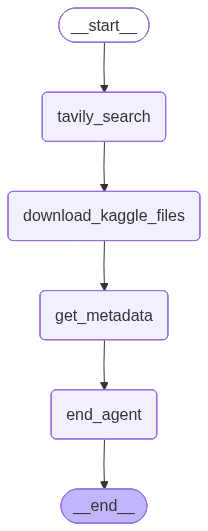

In [12]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(AgentState)

graph.add_node("tavily_search", tavily_search_tool)
graph.add_node("download_kaggle_files", download_kaggle_files)
graph.add_node("get_metadata", get_metadata)
graph.add_node("end_agent", end_agent)

graph.add_edge(START, "tavily_search")
graph.add_edge("tavily_search", "download_kaggle_files")
graph.add_edge("download_kaggle_files", "get_metadata")
graph.add_edge("get_metadata", "end_agent")

final_graph = graph.compile()

from IPython.display import Image, display
display(Image(final_graph.get_graph().draw_mermaid_png()))


In [13]:
query = "climate change dataset"

state = AgentState(query=query)

In [14]:
for event in final_graph.stream(state):
    print(event)

{'tavily_search': {'tavilySearchOutput': [TavilySearchOutput(title='Climate Change Dataset - Kaggle', url='https://www.kaggle.com/datasets/bhadramohit/climate-change-dataset', content='Climate Change Dataset Climate Change Dataset This dataset provides a comprehensive overview of key climate change indicators collected across different countries from the year 2000 to 2024. The country or region where the climate data was collected. The data can be used for machine learning models to predict future climate scenarios, especially in relation to global temperature rise, sea-level changes, and extreme weather events. File Name: climate_change_dataset.csv The year in which the data was recorded (from 2000 to 2024).text_format Country sort The country or region for which the climate data is recorded. The average annual temperature in degrees Celsius for each country.grid_3x3 CO2 Emissions (Tons/Capita)sort The annual sea-level rise in millimeters for coastal regions of the country.grid_3x3 Ra

In [15]:
final_state = {}
for event in final_graph.stream(state):
    print(event)  # intermediate updates
    for _, update in event.items():
        final_state.update(update)

from pprint import pprint
pprint([ds.model_dump() for ds in final_state.get("dataset_outputs", [])][:1])
pprint([fo.model_dump() for fo in final_state.get("file_outputs", [])][:3])

{'tavily_search': {'tavilySearchOutput': [TavilySearchOutput(title='Climate Change Dataset - Kaggle', url='https://www.kaggle.com/datasets/bhadramohit/climate-change-dataset', content='Climate Change Dataset Climate Change Dataset This dataset provides a comprehensive overview of key climate change indicators collected across different countries from the year 2000 to 2024. The country or region where the climate data was collected. The data can be used for machine learning models to predict future climate scenarios, especially in relation to global temperature rise, sea-level changes, and extreme weather events. File Name: climate_change_dataset.csv The year in which the data was recorded (from 2000 to 2024).text_format Country sort The country or region for which the climate data is recorded. The average annual temperature in degrees Celsius for each country.grid_3x3 CO2 Emissions (Tons/Capita)sort The annual sea-level rise in millimeters for coastal regions of the country.grid_3x3 Ra